In [1]:
import os 
import random
import numpy as np
import pandas as pd
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dropout, Flatten, MaxPooling2D, ZeroPadding2D, Dense, Activation, Conv2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import backend as K

%matplotlib inline 

Using TensorFlow backend.


# Load dataset

In [2]:
train_path = "../Dataset/train/"

blood_class = ["MONONUCLEAR", "POLYNUCLEAR"]

width = 128  
height = 128
channels = 3

# Preprocess dataset

In [3]:
# load images from folders
def get_images(blood):
    blood_dir = train_path + "{}".format(blood)
    images = [blood + '/' + im for im in os.listdir(blood_dir)]
    return images

# read and resize images
def read_image(src):
    im = imread(src)
    im = imresize(im, (width, height))
    return im

In [4]:
files = []
y_all = []

for blood in blood_class:
    blood_files = get_images(blood)
    files.extend(blood_files)
    
    y_blood = np.tile(blood, len(blood_files))
    y_all.extend(y_blood)
    print("{0} photos of {1}".format(len(blood_files), blood))
    
y_all = np.array(y_all)

4996 photos of MONONUCLEAR
4961 photos of POLYNUCLEAR


In [5]:
X_all = np.ndarray((len(files), width, height, channels), dtype=np.float32)

for i, im in enumerate(files): 
    X_all[i] = read_image(train_path + im)
    if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))

print("")
print("Shape of resized training images: {}".format(X_all.shape))

Processed 0 of 9957
Processed 1000 of 9957
Processed 2000 of 9957
Processed 3000 of 9957
Processed 4000 of 9957
Processed 5000 of 9957
Processed 6000 of 9957
Processed 7000 of 9957
Processed 8000 of 9957
Processed 9000 of 9957

Shape of resized training images: (9957, 128, 128, 3)


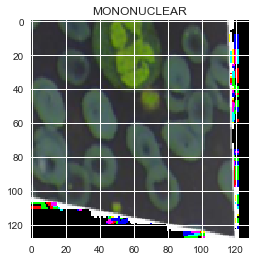

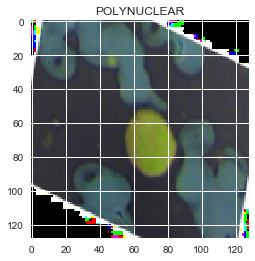

In [6]:
# display blood type from each class
uniq = np.unique(y_all, return_index=True)

for f, i in zip(uniq[0], uniq[1]):
    plt.imshow(X_all[i])
    plt.title(f)
    plt.show()

# Perform one-hot encoding

In [7]:
# One Hot Encoding Labels
y_all = LabelEncoder().fit_transform(y_all)
y_all = np_utils.to_categorical(y_all)

# Split into training and testing set

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=666, stratify=y_all)

In [9]:
# print("Shape of training set: {}".format(X_train.shape))
# print("Shape of testing set: {}".format(X_test.shape))
# print("")
# print("Shape of train label: {}".format(y_train.shape))
# print("Shape of test label: {}".format(y_test.shape))

In [10]:
X_train = X_all
y_train = y_all

# Design convolutional neural network

In [11]:
optimizer = RMSprop(lr=0.0001)
objective = "binary_crossentropy"

def center_normalize(x):
    return (x - K.mean(x)) / K.std(x)

model = Sequential()

model.add(Activation(activation=center_normalize, input_shape=(width, height, channels)))

model.add(Conv2D(32, (5, 5), padding="same", activation="relu"))
model.add(Conv2D(32, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(len(blood_class)))
model.add(Activation("sigmoid"))

model.compile(loss=objective, optimizer=optimizer, metrics=["accuracy"])

In [12]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_1 (Activation)    (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
__________

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')        
        
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.2, verbose=1, shuffle=True, callbacks=[early_stopping])

Train on 7965 samples, validate on 1992 samples
Epoch 1/20
7965/7965 [==============================] - 596s - loss: 0.6653 - acc: 0.6191 - val_loss: 0.9840 - val_acc: 0.0000e+00

Custom CNN network achieves accuracy rate of 0.9953.

# Training loss

In [14]:
def plot_learning_curve(history):
    plt.figure(figsize=(15, 8))
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.title("model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["training set", "validation set"], loc="upper left", fontsize=12)
    plt.clf()
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("CNN model training and validation loss", fontsize=15)
    plt.ylabel("Loss", fontsize=12)
    plt.xlabel("Epoch", fontsize=12)
    plt.legend(["training set", "validation set"], loc="upper left", fontsize=12)

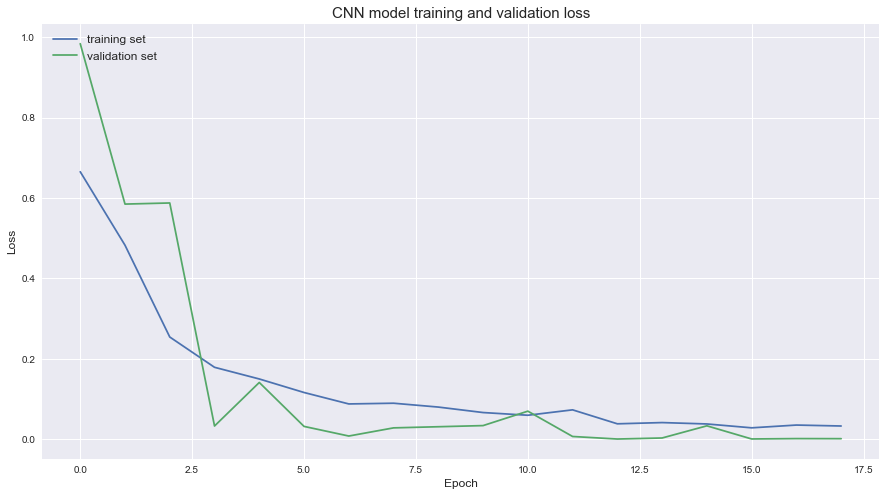

In [15]:
plot_learning_curve(history)

The CNN model converged around 13 epochs.